# Ising Model (incl. Monte Carlo)

## Simulation initialisation & results

In [159]:
%matplotlib inline
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
from types import SimpleNamespace

# Simulation initialisation
sim = SimpleNamespace(time_steps = 1000,
                      L = 5,
                      T = 0.1,
                      dT = 0,
                      h = 0,
                      dh = 0,
                      J = -1,
                      kb = 1,
                      spin_init = 'down')
sim.spin_site_total_number = sim.L**2
sim.MCS = sim.L**2
sim.beta = 1/(sim.kb*sim.T)

results, grid_coordinates_x, grid_coordinates_y = IM_sim(sim)



In [158]:
def IM_sim(self):
    
    grid_coordinates_x, grid_coordinates_y, spin_site_numbers = grid_init(sim)
    grid_spins = assign_spin(sim)
    
    magnitization_total, T_total, h_total, energy_total = matrix_init(sim)
    energy_i = system_energy(grid_coordinates_x, grid_coordinates_y, grid_spins, spin_site_numbers)
    
    for i, t in enumerate(range(self.time_steps)):
        energy_total[i] = energy_i    
        magnitization_total[i] = magnetisation(sim, grid_spins)
        T_total[i] = self.T 
        h_total[i] = self.h

        grid_spins, energy_i = spin_flip_random(self, grid_coordinates_x, grid_coordinates_y, grid_spins, energy_i)
        system_energy(grid_coordinates_x, grid_coordinates_y, grid_spins, spin_site_numbers)
        sim.T += sim.dT
        sim.h += sim.dh
    
    results = SimpleNamespace()
    results.energy = energy_total
    results.magnitization = magnitization_total
    results.temperature = T_total
    results.magnetic_field = h_total
    
    return results, grid_coordinates_x, grid_coordinates_y


## Plotting

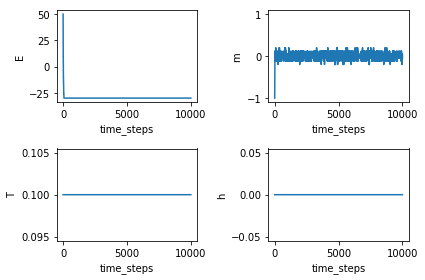

In [160]:
fig = plt.figure()

ax1 = fig.add_subplot(221)
ax1.plot(range(sim.time_steps), results.energy, '-')
plt.xlabel('time_steps')
plt.ylabel('E')

ax2 = fig.add_subplot(222)
ax2.plot(range(sim.time_steps), results.magnitization, '-') # m vs time_steps
# ax2.plot(T_total, magnitization_total[:-1], '-') # m vs T
#ax2.plot([1/0.44, 1/0.44],[-1,1]) # Critical point for J/k_bT = 0.44
plt.ylim([-1.1,1.1])
#plt.xlabel('k_bT/J')
plt.xlabel('time_steps')
plt.ylabel('m')

ax3 = fig.add_subplot(223)
ax3.plot(range(sim.time_steps), results.temperature, '-')
plt.xlabel('time_steps')
plt.ylabel('T')

ax4 = fig.add_subplot(224)
ax4.plot(range(sim.time_steps), results.magnetic_field, '-')
plt.xlabel('time_steps')
plt.ylabel('h')


plt.tight_layout()
fig = plt.gcf()

plt.show()



## Function definitions

In [16]:
def matrix_init(self):
    magnitization_total = np.zeros([self.time_steps, 1])
    T_total = np.zeros([self.time_steps, 1])
    h_total = np.zeros([self.time_steps, 1])
    energy_total = np.zeros([self.time_steps, 1])
    
    return magnitization_total, T_total, h_total, energy_total


def grid_init(self):
    grid_x, grid_y = [range(self.L), range(self.L)]
    grid_coordinates_x, grid_coordinates_y = np.meshgrid(grid_x, grid_y) 
    grid_coordinates_x, grid_coordinates_y = [np.reshape(grid_coordinates_x,(1,-1)), np.reshape(grid_coordinates_y,(1,-1))]
    spin_site_numbers = range(self.spin_site_total_number)
    
    return grid_coordinates_x, grid_coordinates_y, spin_site_numbers


def grid_plot(x, y, S):
    image = plt.imshow(S, extent=(x.min(), x.max(), y.max(), y.min()), interpolation='nearest', cmap=cm.plasma)
    plt.clim(-1,1)
    plt.xlabel('y')
    plt.ylabel('x')
    
    return image


def assign_spin(self):
    if self.spin_init == 'random':
        grid_spins = rnd.rand(self.L, self.L)
        grid_spins[grid_spins >= 0.5] = 1
        grid_spins[grid_spins <  0.5] = -1
        
    elif self.spin_init == 'up':
        grid_spins = np.ones([self.L,self.L], dtype= int)
        
    elif self.spin_init == 'down':
        grid_spins = -1*np.ones([self.L,self.L], dtype= int)
        
    return grid_spins


def spin_site_energy(self, spin_site_x, spin_site_y, grid_spins):
    spin_site_energy = 0
    
    spin_neigbour_x = (spin_site_x + np.array([1, 0, -1, 0]))%(self.L)
    spin_neigbour_y = (spin_site_y + np.array([0, -1, 0, 1]))%(self.L)
    
    for i in range(np.size(spin_neigbour_x)):
        spin_value_center = grid_spins[spin_site_x, spin_site_y]
        spin_value_neighbour = grid_spins[spin_neigbour_x[i], spin_neigbour_y[i]]

        spin_site_energy += -self.J*spin_value_center*spin_value_neighbour - self.h*spin_value_center
        
    return spin_site_energy 


def system_energy(grid_coordinates_x, grid_coordinates_y, grid_spins, spin_site_numbers):
    sys_energy = 0
    for spin_site_number in spin_site_numbers:
        spin_site_x = grid_coordinates_x[0][spin_site_number]
        spin_site_y = grid_coordinates_y[0][spin_site_number]
        sys_energy += spin_site_energy(sim, spin_site_x, spin_site_y, grid_spins)
    sys_energy = sys_energy/2 # To counter double counting of the links
    
    return sys_energy


def spin_flip_accept(self, spin_flip_energy_delta):
    '''If this difference, spin_flip_energy_delta (dE), is < 0 this flip is accepted,
    if dE > 0 this flip is accepted with probability e^-dE/K_bT.
    
    Parameters
    ----------
    self : NameSpace
        contains all the simulation parameters
    spin_flip_energy_delta : float
        containing the energy difference upon a spin flip
        
    Returns
    -------
    boolean
        True if flip is accepted, false if rejected
    '''    
     
    return rnd.binomial(1, np.exp(-spin_flip_energy_delta/(self.kb*self.T))) == 1
    
def spin_flip_random(self, grid_coordinates_x, grid_coordinates_y, grid_spins, E_system):
    '''Uses an algorithm where is spin is chosen at random, flipped, the energy 
    difference is checked. If this difference is < 0 this flip is accepted,
    if dE > 0 this flip is accepted with probability e^-dE/K_bT.
    
    Parameters
    ----------
    self : NameSpace
        contains all the simulation parameters
    grid_coordinates_x : 1D array (L*L, 1)
        containing the x coordinates of the spins
    grid_coordinates_y : 1D array (L*L, 1)
        containing the x coordinates of the spins
    grid_spins : 2D array (L, L)
        containing al the spin values 
    E_system: float
        current value of the system energy

    Returns
    -------
    grid_spins : 2D array (L, L)
        containing al the spin values 
    E_system: float 
        energy of the system, which may have changed upon spin flip
    '''    
    spin_site_number = rnd.randint(0, self.spin_site_total_number)
    spin_site_x = grid_coordinates_x[0][spin_site_number]
    spin_site_y = grid_coordinates_y[0][spin_site_number]
       
    spin_site_energy_pre_flip = spin_site_energy(sim, spin_site_x, spin_site_y, grid_spins)
    grid_spins[spin_site_x, spin_site_y] = -1 * grid_spins[spin_site_x, spin_site_y]
    spin_site_energy_post_flip = spin_site_energy(sim, spin_site_x, spin_site_y, grid_spins) 
    
    spin_flip_energy_delta = spin_site_energy_post_flip - spin_site_energy_pre_flip
        
    if spin_flip_energy_delta <= 0:
        E_system += spin_flip_energy_delta
        
    elif spin_flip_energy_delta > 0:
        
        if  spin_flip_accept(sim, spin_flip_energy_delta):
            E_system += spin_flip_energy_delta
            
        else:  
            grid_spins[spin_site_x, spin_site_y] = -1 * grid_spins[spin_site_x, spin_site_y]
            
    return grid_spins, E_system


def bond_freeze(self, grid_coordinates_x, grid_coordinates_y, grid_spins):
    '''Goes over all the spins in the system and checks the bonds, 
    if they are equal the bond is set to 0 if they are unequal the 
    bond is set to infinity with probability (1 - e^-2J/K_bT).
    
    Parameters
    ----------
    self : NameSpace
        contains all the simulation parameters
    grid_coordinates_x : 1D array (L*L, 1)
        containing the x coordinates of the spins
    grid_coordinates_y : 1D array (L*L, 1)
        containing the x coordinates of the spins
    grid_spins : 2D array (L, L)
        containing al the spin values  


    Returns
    -------
    bonds : 2D array (L*L, 4)
        contains al the bonds present in the system
    '''    
    
    bonds = np.zeros((self.spin_site_total_number, 4))
    chance_value = np.exp(-2*self.J/(self.kb*self.T))
    
    for spin_site_number in spin_site_numbers:
        spin_site_x = grid_coordinates_x[0][spin_site_number]
        spin_site_y = grid_coordinates_y[0][spin_site_number]

        spin_neigbour_x = (spin_site_x + np.array([1, 0, 1, 0]))%(self.L)
        spin_neigbour_y = (spin_site_y + np.array([0, -1, 0, 1]))%(self.L)

        for i in range(np.size(spin_neigbour_x)):
            spin_value_center = grid_spins[spin_site_x, spin_site_y]
            spin_value_neighbour = grid_spins[spin_neigbour_x[i], spin_neigbour_y[i]]
            if spin_value_center * spin_value_neighbour == -1: 
                bonds[spin_site_number, i] = 0
            elif rnd.binomial(1, chance_value) == 1:
                bonds[spin_site_number, i] = 0
            else:
                bonds[spin_site_number, i] = np.inf
                
    return bonds


def magnetisation(self, grid_spins):
    magnetisation = np.sum(np.sum(grid_spins,axis=0))/self.spin_site_total_number
    return magnetisation


'''
def specific_heat(sim, energy_total):
    # Need to implement function which selects E from energy calculated such that the values in E are uncorrelated.
    E = energy_total[]
    
    # Computation of the specific heat and its error
    f = self.beta**2*self.kb/self.spin_site_total_number
    Cv = f*np.var(E)
    Cv_std = f*std(E)
    
    return Cv, Cv_std

def magnetic_susceptibility(sim, magnetisation):
    # Need to implement function which selects m from magnetisation calculated such that the values in magnetisation are uncorrelated.
    m = magnetisation[]
    
    # Computation of the magnetic susceptibility and its error
    f = self.beta*self.spin_site_total_number
    chi = f*np.var(m)
    chi_std  = f*std(m)
    
    return chi, chi_std
'''


'\ndef specific_heat(sim, energy_total):\n    # Need to implement function which selects E from energy calculated such that the values in E are uncorrelated.\n    E = energy_total[]\n    \n    # Computation of the specific heat and its error\n    f = self.beta**2*self.kb/self.spin_site_total_number\n    Cv = f*np.var(E)\n    Cv_std = f*std(E)\n    \n    return Cv, Cv_std\n\ndef magnetic_susceptibility(sim, magnetisation):\n    # Need to implement function which selects m from magnetisation calculated such that the values in magnetisation are uncorrelated.\n    m = magnetisation[]\n    \n    # Computation of the magnetic susceptibility and its error\n    f = self.beta*self.spin_site_total_number\n    chi = f*np.var(m)\n    chi_std  = f*std(m)\n    \n    return chi, chi_std\n'

In [35]:
# Test for optimising bond function
import numpy as np
import numpy.random as rnd

#A_Test = np.array([[1, 2, 3, 4],[5, 6, 7, 8],[9, 10, 11, 12]])
A_Test = np.array([[1, 0, 1, 0],[0, 1, 0, 1],[1, 0, 1, 0]])
print(A_Test)

A_Test_LR = np.roll(A_Test,-1,axis=1)
print(A_Test_LR)

A_Test_UD = np.roll(A_Test,-1,axis=0)
print(A_Test_UD)

diff_LR = np.abs(A_Test-A_Test_LR)
print('diff_LR')
print(diff_LR)



## The actual function:

chance_value = np.exp(-2*sim.J/(sim.kb*self.T))

delta_spin_hor = np.abs(grid_spins-np.roll(grid_spins,-1,axis=1))/2 # Divided by 2 to normalise
# Element (i,j) gives the relation between spin_site (i,j) and (i,j+1). When j+1 does not exist it refers to (i,0) which illustraties the periodic BCs.
nz_delta_spin_hor = np.asarray(np.nonzero(delta_spin_hor)) # Gives array with indices for non-zero elements

delta_spin_ver = np.abs(grid_spins-np.roll(grid_spins,-1,axis=0))/2 # Divided by 2 to normalise
# Element  (i,j) gives the relation between spin_site (i,j) and (i+1,j). When i+1 does not exist it refers to (0,j) which illustraties the periodic BCs.
nz_delta_spin_ver = np.asarray(np.nonzero(delta_spin_ver)) # Gives array with indices for non-zero elements

bonds = np.zeros((L, L, 2),dtype=float) # L x L due to grid size and 2 for vertical and horizontal case. (1st hor, 2nd ver)

for i in range(np.shape(delta_spin_hor)[2]):
    if rnd.binomial(1, chance_value) == 1:
        bonds[delta_spin_hor[0,i],delta_spin_hor[1,i],1] = 0
    else:
        bonds[delta_spin_hor[0,i],delta_spin_hor[1,i],1] = np.inf

for j in range(np.shape(delta_spin_hor)[2]):
    if rnd.binomial(1, chance_value) == 1:
        bonds[delta_spin_ver[0,i],delta_spin_ver[1,i],2] = 0
    else:
        bonds[delta_spin_ver[0,i],delta_spin_ver[1,i],2] = np.inf

[[1 0 1 0]
 [0 1 0 1]
 [1 0 1 0]]
[[0 1 0 1]
 [1 0 1 0]
 [0 1 0 1]]
[[0 1 0 1]
 [1 0 1 0]
 [1 0 1 0]]
diff_LR
[[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]
[ True False  True False]
[False  True False  True]
[ True False  True False]
(array([0, 0, 1, 1, 2, 2]), array([0, 2, 1, 3, 0, 2]))


In [50]:
print(np.asarray(np.nonzero(A_Test)))
print(np.nonzero(A_Test))
print(np.shape(np.asarray(np.nonzero(A_Test))))
print(np.shape(np.asarray(np.nonzero(A_Test)))[1])

[[0 0 1 1 2 2]
 [0 2 1 3 0 2]]
(array([0, 0, 1, 1, 2, 2]), array([0, 2, 1, 3, 0, 2]))
(2, 6)
6


In [55]:
Q=np.asarray(np.nonzero(A_Test))
print(Q[0,1],Q[1,1])

0 2


## Animation function

<IPython.core.display.Javascript object>


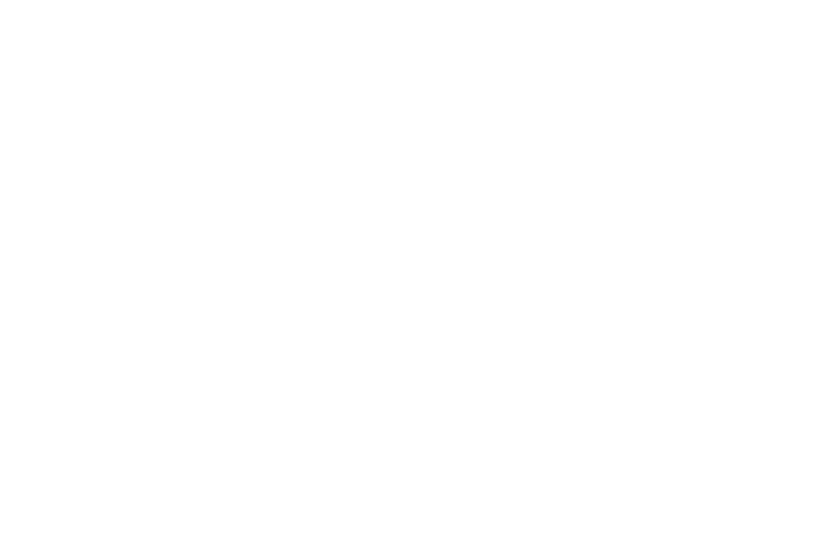

<IPython.core.display.Javascript object>


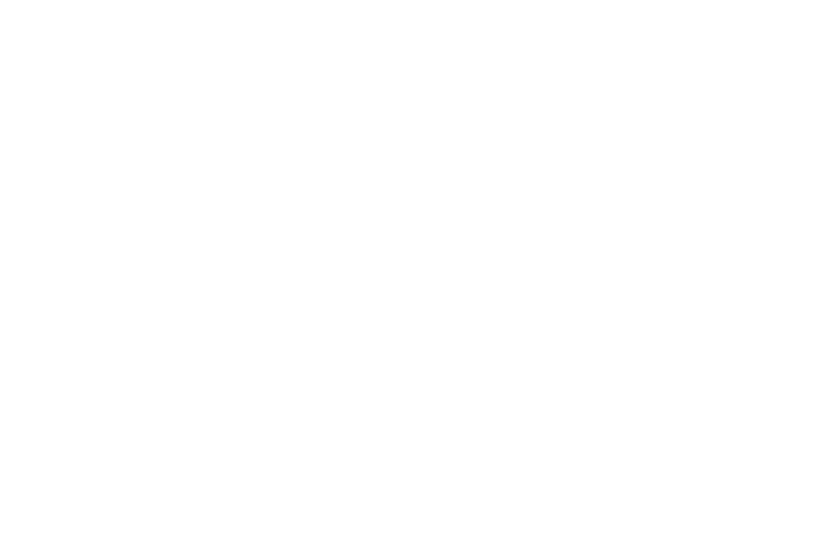

In [15]:
# Needs to be called before matplotlib is imported
%matplotlib notebook 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
from matplotlib.widgets import Slider, Button, RadioButtons


fig2 = plt.figure()

im = plt.imshow(grid_spins, extent=(grid_coordinates_x.min(), grid_coordinates_x.max(), 
                                    grid_coordinates_y.max(), grid_coordinates_y.min()), 
                interpolation='nearest', cmap=cm.plasma, animated=True)
plt.clim(-1, 1)
plt.xlabel('y')
plt.ylabel('x')
plt.colorbar()
axis_color = 'lightgoldenrodyellow'

ax = fig2.add_subplot(111)

# Adjust the subplots region to leave some space for the sliders and buttons
fig2.subplots_adjust(left=0.25, bottom=0.3)


# Add two sliders for tweaking the parameters

# Define an axes area and draw a slider in it
m_slider_ax  = fig2.add_axes([0.25, 0.15, 0.65, 0.03], facecolor=axis_color)
m_slider = Slider(m_slider_ax, 'h', -10.0, 10.0, valinit=sim.h)


# Draw another slider
T_slider_ax = fig2.add_axes([0.25, 0.1, 0.65, 0.03], facecolor=axis_color)
T_slider = Slider(T_slider_ax, 'T', 0.1, 100.0, valinit=sim.T)


# Define an action for modifying the line when any slider's value changes
def sliders_on_changed(val):
    global sim
    sim.h = m_slider.val
    sim.T = T_slider.val

m_slider.on_changed(sliders_on_changed)
T_slider.on_changed(sliders_on_changed)


# Add a button for resetting the parameters
reset_button_ax = fig2.add_axes([0.8, 0.025, 0.1, 0.04])
reset_button = Button(reset_button_ax, 'Reset', color=axis_color, hovercolor='0.975')


def reset_button_on_clicked(mouse_event):
    T_slider.reset()
    m_slider.reset()

reset_button.on_clicked(reset_button_on_clicked)


def updatefig(*args):
    global sim, grid_coordinates_x, grid_coordinates_y, grid_spins, energy_i
    grid_spins, energy_i = spin_flip(sim, grid_coordinates_x, grid_coordinates_y, grid_spins, energy_i)
    im.set_array(grid_spins)
    
    return im,


ani = animation.FuncAnimation(fig2, updatefig, interval=1, blit=True) # for save animation: + ,frames=1000)
#ani.save('animation.mp4')


## Redundant (for now)

In [13]:
'''
def acceptance_prob(self):
    ap = np.exp(-2*beta*self.J*np.array([4, 2, 0, -2, -4])) # 4 (pairs)equal, 3 equal, 2 equal, 1 equal, 0 equal
    return ap
    
'''